# Train models

This notebook will be used to train the models.

## Setup

First, some setup.

#### Mount Google drive

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


### Copy data to VM local disk

In [ ]:
%cd "/content/gdrive/MyDrive/Deep Learning Big Project/Action_Detection_In_Videos/"
! cp datasets/ssv2_mini/images.zip /content/Action_Detection_In_Videos/datasets/ssv2_mini/
! cp datasets/ssv2_mini/frames.zip /content/Action_Detection_In_Videos/datasets/ssv2_mini/
! cp datasets/ssv2_mini/flows.zip /content/Action_Detection_In_Videos/datasets/ssv2_mini/
! cp -R models/ /content/Action_Detection_In_Videos/models/
! cp -R src/ /content/Action_Detection_In_Videos/src/

In [ ]:
%cd /content/Action_Detection_In_Videos/
! unzip -q -d datasets/ssv2_mini datasets/ssv2_mini/images.zip && rm datasets/ssv2_mini/images.zip
! unzip -q -d datasets/ssv2_mini datasets/ssv2_mini/frames.zip && rm datasets/ssv2_mini/frames.zip
! unzip -q -d datasets/ssv2_mini datasets/ssv2_mini/flows.zip && rm datasets/ssv2_mini/flows.zip

### Imports

In [ ]:
import os
import shutil
import pytz
import datetime
from tqdm.auto import tqdm

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import torch
from torch import nn, optim
from torch.utils.data import DataLoader

from src import dataset
from models.temporal_cnn import temporal_CNN
from models.finetuned_resnet import finetuned_resnet

plt.rcParams["animation.html"] = "jshtml"

### Constants

In [ ]:
root = os.path.join('datasets', 'ssv2_mini')
num_classes = 174

batch_size = 32
shuffle = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load data

Now we will load the preprocessed data.

### Instantiate dataloaders

In [ ]:
train_images_dataloader = DataLoader(dataset.SSV2_ProcessedDataset(root, 'images', 'train'), batch_size=batch_size, shuffle=shuffle)
test_images_dataloader = DataLoader(dataset.SSV2_ProcessedDataset(root, 'images', 'test'), batch_size=batch_size, shuffle=shuffle)

train_frames_dataloader = DataLoader(dataset.SSV2_ProcessedDataset(root, 'frames', 'train'), batch_size=batch_size, shuffle=shuffle)
test_frames_dataloader = DataLoader(dataset.SSV2_ProcessedDataset(root, 'frames', 'test'), batch_size=batch_size, shuffle=shuffle)

train_flows_dataloader = DataLoader(dataset.SSV2_ProcessedDataset(root, 'flows', 'train'), batch_size=batch_size, shuffle=shuffle)
test_flows_dataloader = DataLoader(dataset.SSV2_ProcessedDataset(root, 'flows', 'test'), batch_size=batch_size, shuffle=shuffle)

### Dataloader demonstration

<class 'torch.Tensor'> torch.Size([32, 3, 216, 216])
<class 'torch.Tensor'> torch.Size([3, 216, 216])
tensor(142) tensor(0)


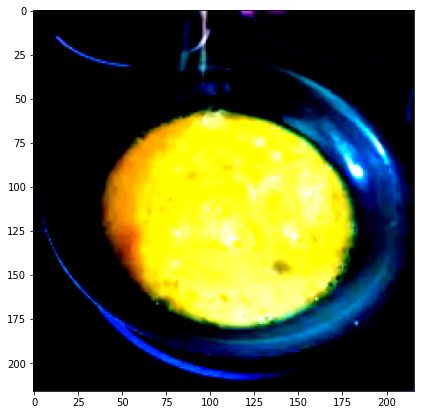

In [ ]:
for images, labels in train_images_dataloader:
    print(type(images), images.shape)

    i = 0
    image, label = images[i], labels[i]
    print(type(image), image.shape, label)
    
    image = image.permute(1, 2, 0).clamp(0, 1).numpy()
    plt.figure(figsize=(7, 7))
    plt.imshow(image)
    break

In [ ]:
def animate_frames(video):
    def get_frame(video, i): # C x L x H x W
        frame = video[:, i, ...].numpy()
        return frame.transpose(1, 2, 0).clip(0, 1) # H x W x C

    fig = plt.figure(figsize=(7, 7))
    im = plt.imshow(get_frame(video, 0))
    plt.close()

    i = 1
    def animate(i):
        im.set_array(get_frame(video, i))
        i += 1
        return im,
    return animation.FuncAnimation(fig, animate, frames=clip.size(1), blit=True)

for batch, labels in train_frames_dataloader:
    print(type(batch), batch.shape) # B x C x L x H x W

    i = 0
    video, label = batch[i], labels[i]
    print(type(video), video.shape, label)

    anim = animate_frames(video)
    break
anim

<class 'torch.Tensor'> torch.Size([32, 3, 10, 216, 216])
<class 'torch.Tensor'> torch.Size([3, 10, 216, 216])
tensor(159) tensor(0)


In [ ]:
def animate_flows(flows):
    flow_len, h, w = flows.shape[1:]
    step = 3
    figsize = (7, 7)

    def get_flow(flows, i, c): # C x L x H x W
        flow = flows[c, i, ::step, ::step].numpy()
        return flow.clip(0, 1) # H x W
    
    fig = plt.figure(figsize=figsize)
    q = plt.quiver(
        np.arange(0, w, step),
        np.arange(h, 0, -step),
        get_flow(flows, 0, 0),
        get_flow(flows, 0, 1),
    )
    plt.close()

    i = 1
    def animate(i):
        q.set_UVC(get_flow(flows, i, 0), get_flow(flows, i, 1))
        i += 1
        return q,
    return animation.FuncAnimation(fig, animate, frames=flow_len, blit=True)

for batch, labels in train_flows_dataloader:
    print(type(batch), batch.shape) # B x C x L x H x W
    i = 0
    flows = batch[i] # C x L x H x W
    print(type(flows), flows.shape)
    label = labels[i]
    print(label, label.argmax())

    anim = animate_flows(flows)
    break
anim

<class 'torch.Tensor'> torch.Size([32, 2, 9, 216, 216])
<class 'torch.Tensor'> torch.Size([2, 9, 216, 216])
tensor(113) tensor(0)


## Training functions

We will use these function to train our models.

### Train function

In [ ]:
def train(model, train_dataloader, test_dataloader, epochs, criterion, optimizer,
          model_dir='temp', start_epoch=1, validate_every=10, save_every=10):
    model.to(device)
    model.train()
    
    # Load checkpoint if starting from a specific epoch
    assert start_epoch >= 1, 'start_epoch must be >= 1'
    if start_epoch == 1:
        history = {}
        total_steps = 1
    else:
        history = load_checkpoint(model_dir, start_epoch, model, optimizer)
        total_steps = history['total_steps']
    
    # Progress bars
    epoch_pbar = tqdm(total=epochs, desc='Epochs', unit=' epoch', initial=start_epoch)
    train_pbar = tqdm(desc='Train', unit=' step', position=1)
    val_pbar = tqdm(desc='Val', unit=' step', position=2)
    
    # Capture start time
    start = time_now()
    tqdm.write(f'Training started at {start}')
    
    # try-except block to catch KeyboardInterrupt
    try:
        for epoch in range(start_epoch, epochs+1):
            step = 1
            steps = int(np.ceil(len(train_dataloader.dataset) / batch_size))
            train_loss = 0.
            train_acc = 0.
            
            # Reset training progress bar
            train_pbar.reset(steps)

            for batch, labels in train_dataloader:
                batch, labels = batch.to(device), labels.to(device)
                
                # Forward-backward propagation
                optimizer.zero_grad()
                output = model.forward(batch)
                loss = criterion(output, labels)
                loss.backward()
                optimizer.step()
                
                # Compute training loss and accuracy
                train_loss += loss.item()
                correct = (labels == output.argmax(-1)).float().detach().cpu().numpy()
                train_acc += correct.mean()
                
                # Update training progress bar
                i = step % validate_every or validate_every # when step is a multiple of validate_every
                update_pbar(train_pbar, f'train_loss={train_loss/i:.3f}, train_acc={train_acc/i:.3f}')
                
                # Validation
                if i == validate_every:
                    model.eval()
                    with torch.no_grad():
                        val_loss, val_acc = validation(model, test_dataloader, criterion, val_pbar)
                    model.train()
                    update_history(history, epoch, epochs, step, steps, total_steps,
                                   train_loss/i, train_acc/i, val_loss, val_acc)
                    train_loss = 0.
                    train_acc = 0.

                # Increment step
                step += 1
                total_steps += 1
            
            # Save checkpoint
            if epoch % save_every == 0:
                save_checkpoint(model, optimizer, history, model_dir, epoch)
        
        # Epoch loop ended successfully
        else:
            status = 'ended'
    
    # Epoch loop was interrupted
    except KeyboardInterrupt:
        status = 'interrupted'
    
    # Capture end time
    end = time_now()
    tqdm.write(f'Training {status} at {end}')
    tqdm.write(f'Time elapsed: {time_elapsed(start, end)}')
    
    # Close progress bars
    epoch_pbar.close()
    train_pbar.close()
    val_pbar.close()

    # Save final checkpoint
    save_checkpoint(model, optimizer, history, model_dir, epoch)

    return history

### Validation function

In [ ]:
def validation(model, dataloader, criterion, pbar): # top 1
    val_loss = 0.
    val_acc = 0.
    step = 1
    steps = np.ceil(len(dataloader.dataset) / batch_size)

    # Reset validation progress bar
    pbar.reset(steps)
    
    for batch, labels in dataloader:
        batch, labels = batch.to(device), labels.to(device)

        # Forward propagation
        output = model.forward(batch)
        loss = criterion(output, labels)

        # Compute validation loss and accuracy
        val_loss += loss.item()
        correct = (labels == output.argmax(-1)).float().detach().cpu().numpy()
        val_acc += correct.mean()
        
        # Update validation progress bar
        update_pbar(pbar, f'val_loss={val_loss/step:.3f}, val_acc={val_acc/step:.3f}')

        # Increment step
        step += 1
    
    return val_loss/step, val_acc/step

### Utility functions

In [ ]:
def save_checkpoint(model, optimizer, history, dst_dir, epoch):
    checkpoint = {}
    checkpoint['model_state_dict'] = model.state_dict()
    checkpoint['optimizer_state_dict'] = optimizer.state_dict()
    checkpoint['history'] = history
    if not os.path.exists(dst_dir):
        os.makedirs(dst_dir)
    dst = os.path.join(dst_dir, f'epoch-{epoch}.pt')
    torch.save(checkpoint, dst)

def load_checkpoint(src_dir, epoch, model, optimizer):
    src = os.path.join(src_dir, f'epoch-{epoch}.pt')
    if not os.path.exists(src):
        raise ValueError(f"Checkpoint '{src}' does not exist")
    checkpoint = torch.load(src)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return checkpoint['history']

def update_history(history, epoch, epochs, step, steps, total_steps,
                   train_loss, train_acc, val_loss, val_acc):
    history.setdefault('epoch', []).append(epoch)
    history.setdefault('total_steps', []).append(total_steps)
    history.setdefault('train_loss', []).append(train_loss)
    history.setdefault('train_acc', []).append(train_acc)
    history.setdefault('val_loss', []).append(val_loss)
    history.setdefault('val_acc', []).append(val_acc)
    tqdm.write(f'Epoch: {epoch}/{epochs} - '
               f'Step: {step}/{steps} (Total {total_steps}) - '
               f'Training Loss: {train_loss:.3f} - '
               f'Training Accuracy: {train_acc:.3f} - '
               f'Validation Loss: {val_loss:.3f} - '
               f'Validation Accuracy: {val_acc:.3f}')

def update_pbar(pbar, postfix):
    pbar.update(1)
    pbar.set_postfix_str(postfix)

def time_now(tz='Singapore'):
    return datetime.datetime.now(tz=pytz.timezone(tz))

def time_elapsed(start, end):
    s = int((end - start).total_seconds())
    return f'{s//60}:{s%60:0>2d}'

### Visualization function

In [ ]:
def calculate_xticks(history):
    ticks = []
    labels = []
    for i in range(len(history['epoch'])):
        if i == 0 or history['epoch'][i] != labels[-1]:
            ticks.append(history['epoch'][i])
            labels.append(history['total_steps'][i])
    return [], []

def plot_history(history):
    fig, ax = plt.subplots(figsize=(10,6))
    
    l1, = ax.plot(history['total_steps'], history['train_acc'], color='blue', label='Training accuracy')
    l2, = ax.plot(history['total_steps'], history['val_acc'], color='orange', label='Validation accuracy')
    # xticks, xticklabels = calculate_xticks(history)
    # ax.set_xticks(xticks)
    # ax.set_xticklabels(xticklabels)
    ax.set_xlabel('Steps')
    ax.set_ylabel('Accuracy')
    
    ax2 = ax.twinx()
    l3, = ax2.plot(history['total_steps'], history['train_loss'], color='blue', linestyle='dotted', label='Training loss')
    l4, = ax2.plot(history['total_steps'], history['val_loss'], color='orange', linestyle='dotted', label='Validation loss')
    ax2.set_ylabel('Loss')
    
    plt.legend(handles=[l1, l3, l2, l4], bbox_to_anchor=(1.1, 1), loc='upper left')
    plt.show()


## Training the models

In this section, we will use the train function to train our models.

#### Hyperparameters

In [ ]:
epochs = 50

adam_params = dict(
    lr = 0.001,
    weight_decay = 1e-6,
    betas = (0.9, 0.999),
)

### Fine-tuned ResNet (Two-stream)

This model will take in an image (first frame of a video) and output the predicted class of the sample.

Training started at 2021-05-03 22:15:43.387479+08:00
Epoch: 1/50 - Step: 10/109 (Total 10) - Training Loss: 5.160 - Training Accuracy: 0.003 - Validation Loss: 4.873 - Validation Accuracy: 0.003
Epoch: 1/50 - Step: 20/109 (Total 20) - Training Loss: 5.162 - Training Accuracy: 0.003 - Validation Loss: 4.873 - Validation Accuracy: 0.005
Epoch: 1/50 - Step: 30/109 (Total 30) - Training Loss: 5.154 - Training Accuracy: 0.016 - Validation Loss: 4.875 - Validation Accuracy: 0.005
Epoch: 1/50 - Step: 40/109 (Total 40) - Training Loss: 5.162 - Training Accuracy: 0.006 - Validation Loss: 4.874 - Validation Accuracy: 0.005
Epoch: 1/50 - Step: 50/109 (Total 50) - Training Loss: 5.163 - Training Accuracy: 0.003 - Validation Loss: 4.873 - Validation Accuracy: 0.005
Epoch: 1/50 - Step: 60/109 (Total 60) - Training Loss: 5.162 - Training Accuracy: 0.006 - Validation Loss: 4.873 - Validation Accuracy: 0.005
Epoch: 1/50 - Step: 70/109 (Total 70) - Training Loss: 5.159 - Training Accuracy: 0.013 - Valid

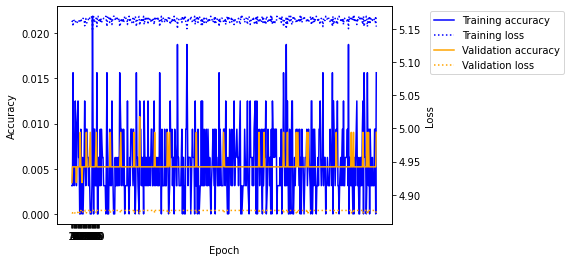

In [ ]:
model = finetuned_resnet(num_classes, include_top=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), **adam_params)

history = train(model, train_images_dataloader, test_images_dataloader, epochs, criterion, optimizer, 'weights/fine-tuned ResNet(Two-stream)')
plot_history(history)

### Simple CNN (Two-stream)

This model will take in the optical flow data of a video and output the predicted class of the sample.

In [ ]:
# TODO
model = temporal_CNN()

### Fine-tuned ResNet (LRCN)

This model will take in a sequence of frames and output an embedding of each frame to be passed into the LSTM.

In [ ]:
# KIV